<h2> compare two model result </h2>


<h3>1. Load both models</h3>

In [59]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [60]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH1 = "model/baseline_resnet50.pth"
MODEL_PATH2 = "model/baseline_randomized_resnet50.pth"
TEST_DIR = "data/validation"
TRAIN_DIR = "data/train"
BATCH_SIZE = 24
NUM_CLASSES = len(os.listdir(TRAIN_DIR))
print(DEVICE)


cuda


In [61]:
# Load model 1
model1 = models.resnet50(pretrained=True)
model1.fc = nn.Linear(model1.fc.in_features, NUM_CLASSES)
model1.load_state_dict(torch.load(MODEL_PATH1, map_location=DEVICE))
model = model1.to(DEVICE)
model1.eval()

c:\Users\AOIpc\miniconda3\envs\clean_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AOIpc\miniconda3\envs\clean_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<h3> 2. Create Accuracy Testing  and t-SNE for both model </h3>

In [62]:
# create data Loader
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
classes = test_dataset.classes
print(f'Classes: {classes}')
print(f'Number of test samples: {len(test_dataset)}')

Classes: ['aeroplane', 'bicycle', 'bus', 'car', 'horse', 'knife', 'motorcycle', 'person', 'plant', 'skateboard', 'train', 'truck']
Number of test samples: 55388


In [63]:
# Prediction using model 1 on test dataset
all_test_labels1 = []
all_test_preds1 = []
all_test_feature1 = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model1(inputs)
        _, preds = torch.max(outputs, 1)

        all_test_feature1.extend(outputs.cpu().numpy())
        all_test_labels1.extend(labels.cpu().numpy())
        all_test_preds1.extend(preds.cpu().numpy())

all_labels = np.array(all_test_labels1)
all_preds = np.array(all_test_preds1)

# Overall Accuracy
accuracy = np.mean(all_preds == all_labels)
print(f'Baseline Model Accuracy on Real Test Set: {accuracy:.4f}')

# Classification Report
report = classification_report(all_labels, all_preds, target_names=classes)
print('Classification Report:\n', report)

Baseline Model Accuracy on Real Test Set: 0.1978
Classification Report:
               precision    recall  f1-score   support

   aeroplane       0.34      0.25      0.28      3646
     bicycle       0.67      0.00      0.00      3475
         bus       0.12      0.25      0.16      4690
         car       0.20      0.72      0.32     10401
       horse       0.00      0.00      0.00      4691
       knife       0.00      0.00      0.00      2075
  motorcycle       0.64      0.00      0.00      5796
      person       0.00      0.00      0.00      4000
       plant       0.13      0.02      0.04      4549
  skateboard       0.15      0.01      0.02      2281
       train       0.26      0.29      0.27      4236
       truck       0.12      0.01      0.02      5548

    accuracy                           0.20     55388
   macro avg       0.22      0.13      0.09     55388
weighted avg       0.23      0.20      0.12     55388



<h3>confusion matrix for model 1 here </h3>

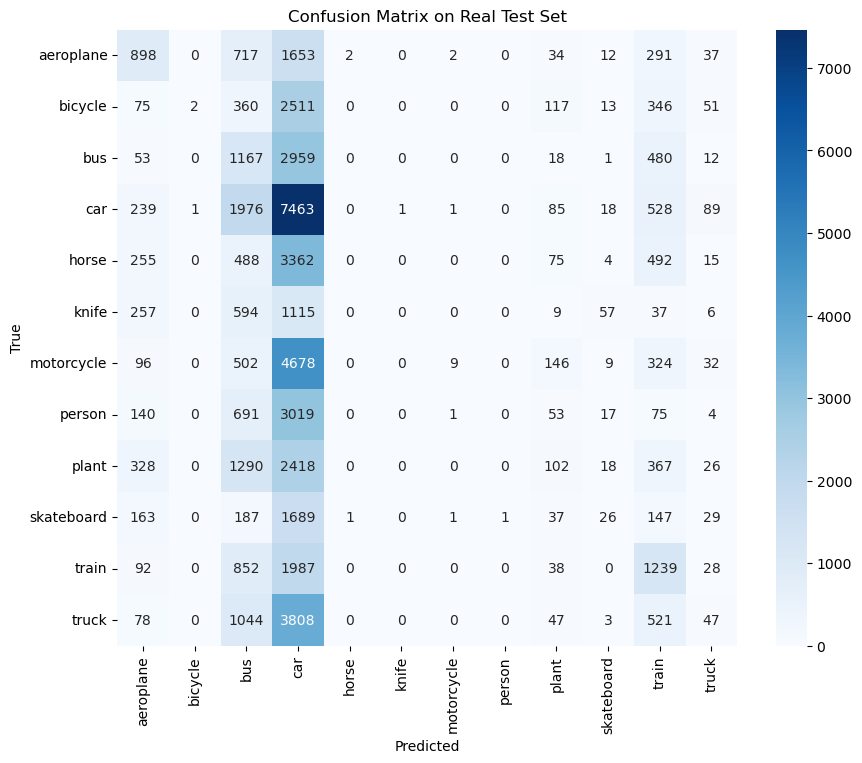

In [64]:
# Code to confusion matrix from model 1
from matplotlib import pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Real Test Set')
plt.show()

In [65]:
# Prediction using model 1 on train dataset
all_train_labels1 = []
all_train_preds1 = []
all_train_feature1 = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model1(inputs)
        _, preds = torch.max(outputs, 1)
        all_train_feature1.extend(outputs.cpu().numpy())
        all_train_labels1.extend(labels.cpu().numpy())
        all_train_preds1.extend(preds.cpu().numpy())

all_labels = np.array(all_train_labels1)
all_preds = np.array(all_train_preds1)

# Overall Accuracy
accuracy = np.mean(all_preds == all_labels)
print(f'Baseline Model Accuracy on train Set: {accuracy:.4f}')

# Classification Report
report = classification_report(all_labels, all_preds, target_names=classes)
print('Classification Report:\n', report)

Baseline Model Accuracy on train Set: 0.9964
Classification Report:
               precision    recall  f1-score   support

   aeroplane       1.00      1.00      1.00     14309
     bicycle       0.99      1.00      1.00      7365
         bus       1.00      0.98      0.99     16640
         car       1.00      1.00      1.00     12800
       horse       1.00      1.00      1.00      9512
       knife       1.00      1.00      1.00     14240
  motorcycle       1.00      1.00      1.00     17360
      person       1.00      1.00      1.00     12160
       plant       1.00      1.00      1.00     10731
  skateboard       1.00      1.00      1.00     11680
       train       0.98      1.00      0.99     16000
       truck       0.99      1.00      0.99      9600

    accuracy                           1.00    152397
   macro avg       1.00      1.00      1.00    152397
weighted avg       1.00      1.00      1.00    152397



In [66]:
np.array(all_train_feature1).shape,np.array(all_test_feature1).shape

((152397, 13), (55388, 13))

In [67]:
# create feature for tSNE
label1 = [0]*len(all_train_feature1)
features = np.concatenate([all_train_feature1, all_test_feature1])
features.shape

(207785, 13)

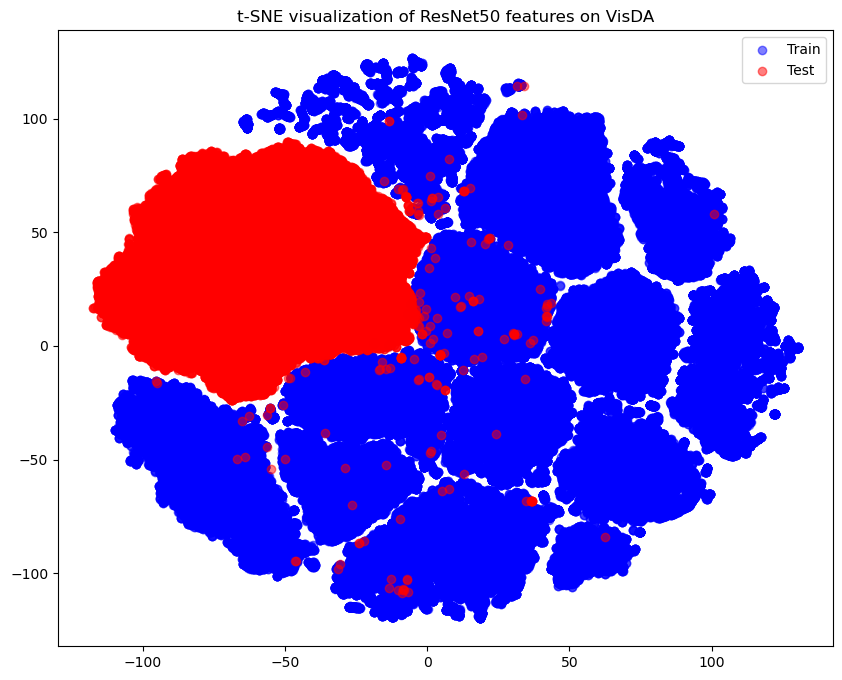

In [68]:
# Create TSNE for model 1
# t-sne visualization on between train and test to check the distribution distribution between source and target domain
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(features)

# 6. Plot
plt.figure(figsize=(10, 8))
plt.scatter(features_2d[:len(label1),0],
            features_2d[:len(label1),1],
            c='blue', alpha=0.5, label='Train')
plt.scatter(features_2d[len(label1):,0],
            features_2d[len(label1):,1],
            c='red', alpha=0.5, label='Test')

plt.legend()
plt.title("t-SNE visualization of ResNet50 features on VisDA")
plt.show()

<h1> Repeat the same thing for model 2 </h1>

In [69]:
# Load model 2


In [70]:
# Prediction using model 2 on test dataset


In [71]:
# confusion matrix for test dataset

In [72]:
# Prediction using model 2 on train dataset


In [73]:
# confusion matrix for train dataset

In [74]:
# t-sne visualization on between train and test to check the distribution distribution between source and target domain